In [16]:
# | default_exp model

%load_ext autoreload
%autoreload 2

%env TOKENIZERS_PARALLELISM=false

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: TOKENIZERS_PARALLELISM=false


In [17]:
# | export
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter


from torch.nn import functional as F
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    trainers,
    Tokenizer,
)
from tokenizers import ByteLevelBPETokenizer


from typing import Optional
import math
import os
from transformers import GPT2TokenizerFast
from my_transformer.attention import unidirectional_mask, MultiHeadAttention, LayerNormalization
from my_transformer.utils import save_model, load_model

In [18]:
from icecream import ic
from matplotlib import pyplot as plt


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

## Model

In [19]:
# | export


class FeedForward(nn.Module):
    def __init__(self, model_size: int, mlp_factor: int = 4, dropout: float = 0.1) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(model_size, mlp_factor * model_size),
            nn.RELU(),
            nn.Linear(mlp_factor * model_size, model_size),
            nn.Dropout(dropout),
        )

        def forward(self, x):
            return self.net(x)


class DecoderLayer(nn.Module):
    def __init__(
        self, model_size: int, nb_heads: int = 1, dropout: float = 0.0, bias: bool = True, mlp_factor=4
    ) -> None:
        super().__init__()
        self.layer_norm1 = LayerNormalization(model_size)  # LayerNormalization(model_size)
        self.attn = MultiHeadAttention(d=model_size, h=nb_heads, dropout=dropout, bias=bias)
        self.mlp1 = nn.Linear(model_size, mlp_factor * model_size, bias=bias)
        self.mlp2 = nn.Linear(mlp_factor * model_size, model_size, bias=bias)
        self.activation = nn.ReLU()
        self.layer_norm2 = LayerNormalization(model_size)  # LayerNormalization(model_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        b, l, d = x.size()
        norm_x = self.layer_norm1(x)
        attn_x = x + self.attn(norm_x, z=None, mask=mask)[0]

        norm_attn_x = self.layer_norm2(attn_x)
        lin1 = self.activation(self.mlp1(norm_attn_x))
        x = x + self.dropout(self.mlp2(lin1))
        return x

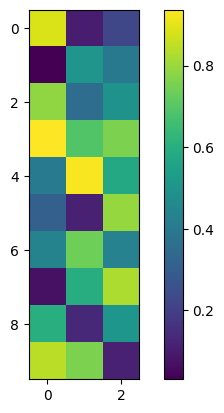

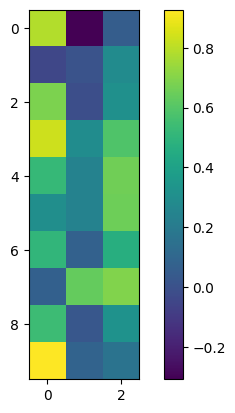

In [20]:
batch_size = 1
seq_len = 10
embedding_dim = 3
x = torch.rand((batch_size, seq_len, embedding_dim)).to(device)
dl = DecoderLayer(embedding_dim, nb_heads=1, dropout=0.1).to(device)
mask = unidirectional_mask(seq_len=seq_len).to(device)
dlo = dl(x, mask=mask)

plt.imshow(x[0].cpu().detach())
plt.colorbar()
plt.show()

plt.imshow(dlo[0].cpu().detach())
plt.colorbar()
plt.show()

In [21]:
# | export


class DecoderTransformer(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        max_seq_len: int,
        model_size: int,
        nb_heads: int = 1,
        nb_layers: int = 1,
        dropout: float = 0.0,
        bias: bool = True,
    ) -> None:
        super().__init__()
        self.max_seq_len = max_seq_len
        self.tok_emb = nn.Embedding(vocab_size, embedding_dim=model_size)
        self.pos_emb = torch.nn.Embedding(max_seq_len, embedding_dim=model_size)

        self.layers = nn.Sequential(
            *[
                DecoderLayer(model_size=model_size, nb_heads=nb_heads, dropout=dropout, bias=bias)
                for i in range(nb_layers)
            ]
        )
        self.layer_norm = LayerNormalization(model_size)
        self.unembedding = nn.Linear(model_size, vocab_size)

    def get_device(self):
        # Check the device of parameters or buffers
        if next(self.parameters(), None) is not None:
            return next(self.parameters()).device
        elif next(self.buffers(), None) is not None:
            return next(self.buffers()).device
        else:
            return None  # No parameters or buffers in this module

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, L = x.size()
        tok_emb = self.tok_emb(x)
        device = self.get_device()
        pos_emb = self.pos_emb(torch.arange(L, device=device))
        mask = unidirectional_mask(seq_len=L).to(device)
        x = tok_emb + pos_emb
        # x = self.layers(x, mask)
        for layer in self.layers:
            x = layer(x, mask)
        x = self.layer_norm(x)
        logits = self.unembedding(x)
        return logits

    def generate(self, x: torch.Tensor, max_new_tokens: int):
        with torch.no_grad():
            for i in range(max_new_tokens):
                # we take at most max_seq_len tokens
                x_block = x[:, -self.max_seq_len :]
                logits = self(x_block)
                # we take the logit for last token, used to predict token.
                logits = logits[:, -1, :]
                probs = F.softmax(logits, dim=-1)
                tok_next = torch.multinomial(probs, num_samples=1)
                x = torch.cat((x, tok_next), dim=1)
        return x

In [22]:
def print_model_size(model: nn.Module):
    ic(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")


model = DecoderTransformer(vocab_size=6, max_seq_len=5, model_size=10, nb_heads=1).to(device)
print_model_size(model)
x = torch.tensor([[0, 1, 2, 3, 4], [1, 2, 3, 4, 5]], dtype=torch.int, device=device)
y_hat = model(x)
ic(y_hat.shape)
model.generate(torch.tensor([[0, 1]], dtype=torch.long, device=device), max_new_tokens=5)

ic| sum(p.numel() for p in model.parameters()) / 1e6: 0.001526
    "M parameters": 'M parameters'
ic| y_hat.shape: torch.Size([2, 5, 6])


tensor([[0, 1, 2, 5, 3, 0, 0]], device='mps:0')

## Dataset

In [23]:
with open("../dataset/shakespeare.txt") as f:
    text = f.read()


words = text.split(" ")
train_pos = math.ceil(len(words) * 0.8)
train_words = words[:train_pos]
test_words = words[train_pos:]
train_txt = " ".join(train_words[:])
test_txt = " ".join(test_words[:])

## Tokenizer

GPT2 use a byte-level BPE (byte pair encoding) tokenizer. First we train a tokenizer to create a vocabulary and merge file that is required by GPT2.
GPT-2 expects:
- A fixed vocabulary size (e.g., 50,257 tokens).
- Specific special tokens (<|endoftext|>).
- Byte-level encoding to handle all possible text inputs (including non-standard characters).

So GPT2TokenizerFast enrich trained tokenizer

In [24]:
trained_tokenizer = ByteLevelBPETokenizer()
trained_tokenizer.train_from_iterator([train_txt], vocab_size=1000)
tok_dir = "./shakespare_tok"
os.makedirs(tok_dir, exist_ok=True)
trained_tokenizer.save_model(tok_dir)
tokenizer = GPT2TokenizerFast.from_pretrained(tok_dir)
tokenizer

GPT2TokenizerFast(name_or_path='./shakespare_tok', vocab_size=1000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1000: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)

In [25]:
ic(len(tokenizer.encode(train_txt)) <= len(train_txt))
tokenizer.encode("hello")

ic| len(tokenizer.encode(train_txt)) <= len(train_txt): True


[257, 273, 78]

In [26]:
class BPEDataset(Dataset):
    def __init__(self, text: str, tokenizer: Tokenizer, seq_len: int = 20, device: str = "cpu"):
        self.device = device
        self.seq_len = seq_len
        self.text = text
        self.tokenizer = tokenizer

        self.encoded = torch.tensor(self.tokenizer.encode(self.text), dtype=torch.long, device=device)

    def __len__(self):
        return len(self.encoded) // self.seq_len

    def __getitem__(self, idx):
        data_len = len(self.encoded)
        i = idx * self.seq_len
        if i >= data_len:
            raise ValueError(f"idx {idx} bigger than data length {data_len}")
        x = self.encoded[i : i + self.seq_len]
        y = self.encoded[i + 1 : i + self.seq_len + 1]
        return x, y

In [27]:
train_ds = BPEDataset(train_txt, tokenizer=tokenizer, seq_len=10, device=device)
train_dl = DataLoader(train_ds, batch_size=5)
assert next(iter(train_dl))[0].size() == (5, 10)

In [28]:
# | export


from datetime import datetime


class EpochTrainer:
    def __init__(
        self,
        # model: nn.Module,
        get_new_model: callable,
        optimizer: torch.optim.Optimizer,
        train_dl: DataLoader,
        test_dl: DataLoader,
        model_version: str,
        model_name: str,
        nb_epochs: int = 100,
        loss_fn=F.cross_entropy,
        do_save_model: bool = True,
        save_every_epoch_nb: int = 20,
        device: str = "cpu",
    ) -> None:
        self.model = get_new_model()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.train_dl = train_dl
        self.test_dl = test_dl
        self.nb_epochs = nb_epochs
        self.do_save_model = do_save_model
        self.save_every_epoch_nb = save_every_epoch_nb
        self.model_name = model_name
        self.model_version = model_version
        self.device = device
        self.writer = None

    def compute_loss(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        B, T, C = logits.shape
        logits = logits.view(B * T, C)
        targets = targets.view(B * T)
        loss = self.loss_fn(logits, targets)
        return loss

    @torch.no_grad()
    def estimate_loss(self, i: int):
        out = {}
        self.model.eval()
        for split in ["train", "test"]:
            dl = self.train_dl if split == "train" else self.test_dl
            if dl is not None:
                losses = []
                for x, y in dl:
                    logits = self.model(x)
                    loss = self.compute_loss(logits, y)
                    losses.append(loss.item())
                loss_mean = torch.tensor(losses).mean()
                out[split] = loss_mean
                self.writer.add_scalar(f"{split} loss", loss_mean, i)
        self.model.train()
        return out

    def train(self, from_epoch: int = 0):
        self.writer = SummaryWriter(
            f"../runs/{self.model_name}_{self.model_version}/{datetime.now().strftime('%m-%d-%Y_%H:%M:%S')}"
        )
        ex_x, ex_y = next(iter(self.train_dl))
        self.writer.add_graph(self.model, (ex_x), use_strict_trace=False)
        self.writer.flush()
        if from_epoch > 0:
            epoch_start_nb = from_epoch + 1
        else:
            epoch_start_nb = 0
        nb_epochs_computed = self.nb_epochs - epoch_start_nb
        with tqdm(
            total=len(self.train_dl) * nb_epochs_computed,
            desc=f"Epoch {nb_epochs_computed} times batch ({len(self.train_dl)})",
            unit="batch",
        ) as pbar:
            for curr_epoch in range(epoch_start_nb, self.nb_epochs):
                for b, (xb, yb) in enumerate(self.train_dl):
                    if device == "mps":
                        logits = self.model(xb)
                        loss = self.compute_loss(logits, yb)
                    else:
                        # use bf16 when possible based on autocast rules. bf16 is same range than float32, but less precision.
                        with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                            logits = self.model(xb)
                            loss = self.compute_loss(logits, yb)
                    self.optimizer.zero_grad(set_to_none=True)
                    loss.backward()
                    self.optimizer.step()
                    pbar.update(1)

                losses = self.estimate_loss(curr_epoch)
                pbar.set_postfix(
                    {
                        "epoch": curr_epoch,
                        "train_loss": f"{losses.get('train',torch.inf):.4f}",
                        "test_loss": f"{losses.get('test', torch.inf):.4f}",
                    }
                )
                # print(f"epoch {curr_epoch}: train loss {losses.get('train',torch.inf):.4f}, val loss {losses.get('test', torch.inf):.4f}")
                for name, weight in self.model.named_parameters():
                    self.writer.add_histogram(name, weight, curr_epoch)

                # every once in a while evaluate the loss on train and val sets
                if self.do_save_model:
                    if curr_epoch % self.save_every_epoch_nb == 0:
                        save_model(self.model, self.model_name, self.model_version, curr_epoch)

        if self.do_save_model:
            save_model(self.model, self.model_name, self.model_version, curr_epoch)


torch.manual_seed(42)

batch_size = 64  # how many independent sequences will we process in parallel?
seq_len = 128  # what is the maximum context length for predictions?
vocab_size = 5000
model_size = 384
num_heads = 1
num_layers = 2
dropout = 0.2
nb_epoch = 1
last_epoch_nb = 0
model_name = "gpt2"
model_version = f"t{vocab_size}_0.1"

train_ds = BPEDataset(train_txt, tokenizer=tokenizer, seq_len=seq_len, device=device)
train_dl = DataLoader(train_ds, batch_size=batch_size)
test_ds = BPEDataset(test_txt, tokenizer=tokenizer, seq_len=seq_len, device=device)
test_dl = DataLoader(test_ds, batch_size=batch_size)


tr = EpochTrainer(
    get_new_model=lambda: DecoderTransformer(
        vocab_size=vocab_size,
        max_seq_len=seq_len,
        model_size=model_size,
        nb_heads=num_heads,
        nb_layers=num_layers,
        dropout=dropout,
    ).to(device),
    optimizer=torch.optim.AdamW(model.parameters(), lr=3e-4),
    train_dl=train_dl,
    test_dl=test_dl,
    loss_fn=F.cross_entropy,
    nb_epochs=nb_epoch,
    do_save_model=True,
    save_every_epoch_nb=20,
    model_name=model_name,
    model_version=model_version,
    device=device,
)
tr.train(from_epoch=last_epoch_nb)

Epoch 1 times batch (45): 100%|██████████| 45/45 [00:07<00:00,  6.10batch/s, epoch=0, train_loss=8.6516, test_loss=8.6559]
